# Assignment4

## Part1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
import torch.optim as optim
import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns

In [2]:
# where to put the data
data_path = './'

# this constructs a CIFAR10 dataset, selects the training part of it, 
# downloads it if necessary, and adds additional transforms that we 
# will need to convert each image to a pytorch tensor AND to provide
# a nice conversion of the RGB images into greyscale
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [4]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [5]:
label_map = {1: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7}
class_names = ['automobile','cat','deer',
               'dog','frog','horse','ship','truck']

cifar2_test = [(img, label_map[label])
              for img, label in cifar10_val
              if label  not in [0, 2]]

In [4]:
def training_loop(n_epochs, optimizer, model, loss_fn, dataloader_dict):
    # Setting the device to cuda if available
    device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    
    # Sending the model to device selected
    model.to(device)

    # Making a list for accuracies
    train_acc_list = []
    val_acc_list = []
    
    for epoch in range(1, n_epochs + 1):
        # To track train and validation accuracies for each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            loss_train = 0.0
            epoch_correct = 0
            for imgs, labels in dataloader_dict[phase]:
                imgs, labels = imgs.to(device), labels.to(device)
                # zero the gradients and determine backpropagation
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(imgs)
                    loss = loss_fn(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    # Backward if the phase is train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    loss_train += loss.item() * imgs.size(0)
                    # Calculating the number of correct predictions
                    epoch_correct += torch.sum(preds == labels.data)
            # Calculating epoch loss and accuracy
            epoch_loss = loss_train / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_correct.double() / len(dataloader_dict[phase].dataset)
            if phase == 'train':
                train_acc_list.append(epoch_acc.cpu())
            else:
                val_acc_list.append(epoch_acc.cpu())
            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    
    return model, train_acc_list, val_acc_list

In [8]:
# Making dictionary for dataloaders to track accuracies
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,shuffle=False, num_workers=4)
dataloaders_dict = {"train": train_loader, "val": val_loader}

In [2]:
# Make 20 random seed for testing
def get_random_seeds(seeds):
    assert len(seeds) > 20, "Need at least 20 seeds"
    random_seed = random.sample(seeds, 20)

    return random_seed

In [3]:
# Setting the options for seeds
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)

In [12]:
def experiment(random_seeds, model, n_epochs, learning_rate, dataloaders_dict):
    # These options are needed when seeds are changed
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # Placeholder for models for each seed
    model_dict = {}
    for seed in random_seeds:
        set_seed(seed)
        # Resetting the parameters of models for each seed
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        # Setting the Cross Entropy Loss
        loss_fn = nn.CrossEntropyLoss()

        # Setting the optimizer
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        trained_model, train, val = training_loop(n_epochs, optimizer, model, loss_fn, dataloaders_dict)
        # PLotting the accuracies for each seed
        errors = [np.abs(t-v) for t,v in zip(train,val)]
        plt.errorbar(range(1, n_epochs + 1), train, yerr=errors, label="train")
        plt.errorbar(range(1, n_epochs + 1), val, yerr=errors, label="val")
        plt.title("Training and Validation Accuracy for seed {}".format(seed))
        plt.legend(loc="upper left")
        plt.show()
        model_dict[str(seed)] = trained_model

In [13]:
random_seeds = get_random_seeds(range(1000))
model = Net()

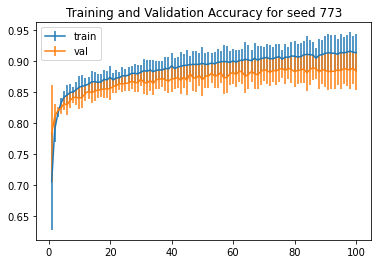

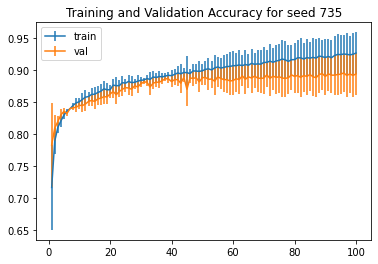

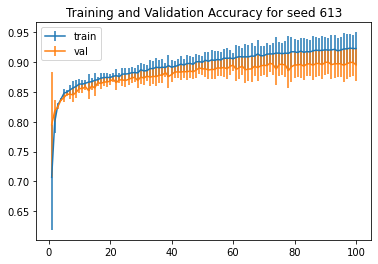

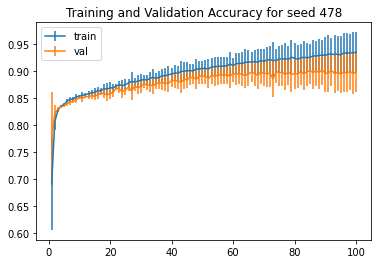

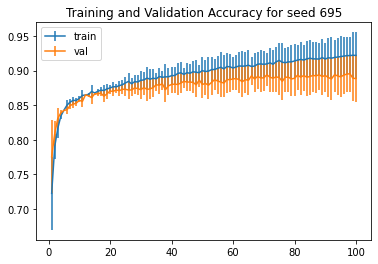

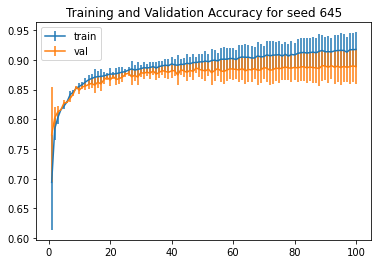

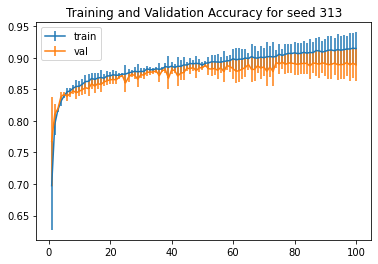

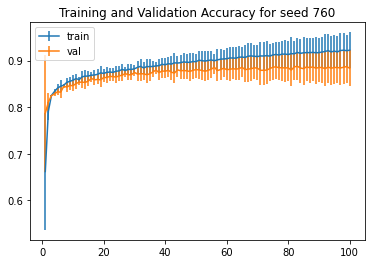

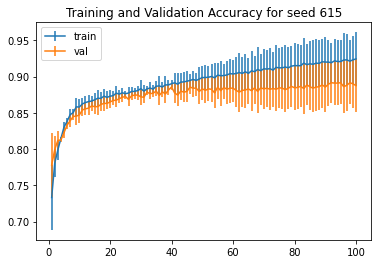

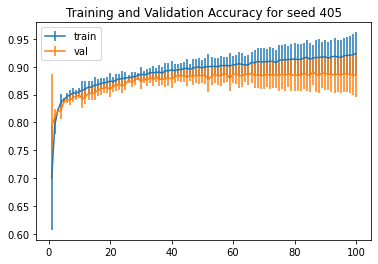

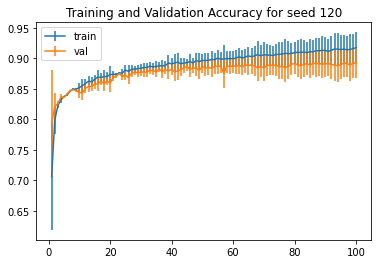

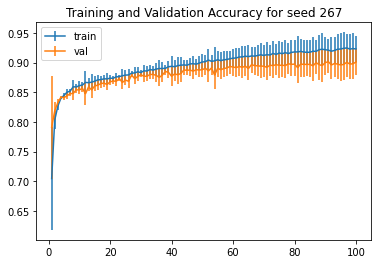

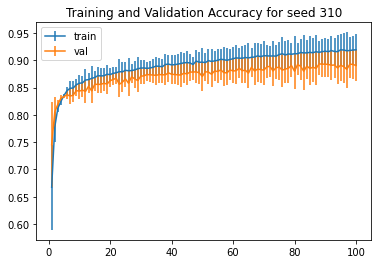

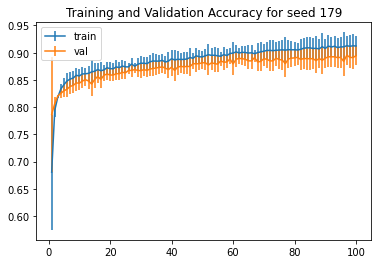

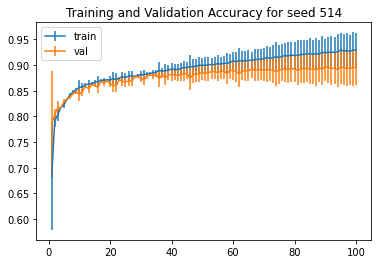

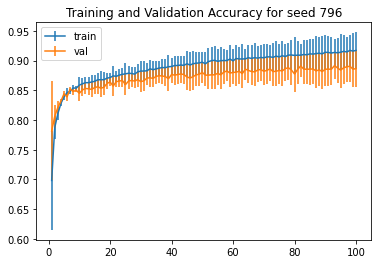

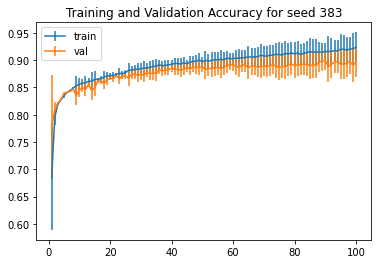

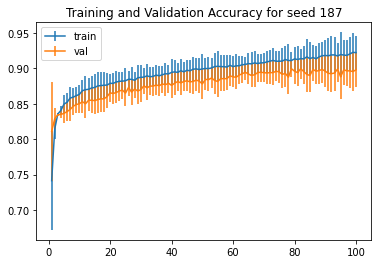

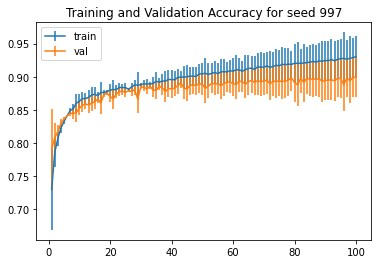

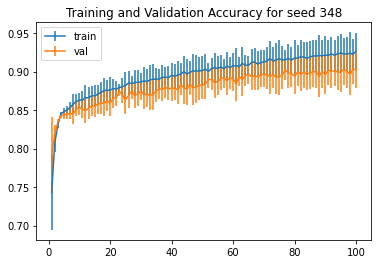

In [14]:
experiment(random_seeds, model, 100, 1e-4, dataloaders_dict)
# experiment(random_seeds, model, 10, 1e-4, dataloaders_dict)

### Q1
The network has been trained well, it can be seen in the accuracies increasing durning the iteration.

### Q2
I think it's not that large, because it has a little different on accuracies, but the diffences is about 1~2%.

### Q3


In [15]:
print(class_names)
test_loader = torch.utils.data.DataLoader(cifar2_test, batch_size=1, shuffle=True)

['automobile', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [37]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

In [16]:
idx = 0
for imgs, labels in test_loader:
    idx +=1
    with torch.no_grad():
        imgs = imgs.to(device= device)
        labels = labels.to(device = device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        print("label: {} <-----> prediction : {}".format(class_names[labels.item()], ['airplane', 'bird'][predicted.item()]))
    if idx == 100:
        break

label: deer <-----> prediction : bird
label: automobile <-----> prediction : airplane
label: deer <-----> prediction : bird
label: automobile <-----> prediction : bird
label: deer <-----> prediction : bird
label: dog <-----> prediction : bird
label: frog <-----> prediction : airplane
label: dog <-----> prediction : bird
label: ship <-----> prediction : airplane
label: cat <-----> prediction : bird
label: horse <-----> prediction : bird
label: automobile <-----> prediction : airplane
label: truck <-----> prediction : bird
label: frog <-----> prediction : bird
label: automobile <-----> prediction : airplane
label: cat <-----> prediction : bird
label: dog <-----> prediction : bird
label: frog <-----> prediction : bird
label: automobile <-----> prediction : airplane
label: automobile <-----> prediction : airplane
label: horse <-----> prediction : bird
label: automobile <-----> prediction : airplane
label: deer <-----> prediction : bird
label: deer <-----> prediction : bird
label: automobil

It seems that model predict living things to 'bird' and inanimate to 'airplane'

Moreover the model do not focus on the common feature "flying"about airplane and bird just focusing on "alive"

It is quite convincing.

However, we wonder what features have been extracted for "alive" about pixel(or visual) level.

### Q4
No I wouldn't use it for real world, because the model was trained with too small resolution data and, for real world data, there could be occlusion and some other noises. So, I think the model couldn't classify well.

## Part2

In [17]:
class NetWidth(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 //2, kernel_size=3,padding=1)
        self.fc1 = nn.Linear(8*8*n_ch1//2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8*8*self.n_ch1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [18]:
class NetDropout(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        # add the dropout layer
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1)
        # add the dropout layer
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        # add call to dropout
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        # add call to dropout
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_ch1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [19]:
class NetBatchNormalization(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        # note that it is also possible to use "bias=False" here, as the 
        # batch normalization layer "cancels" the effect of any bias - see below
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1, bias = "False")
        # add the batch normalization layer
        self.conv1_batchnorm = nn.BatchNorm2d(num_features = n_ch1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1, bias = "False")
        # add the batch normalization layer
        self.conv2_batchnorm = nn.BatchNorm2d(num_features = n_ch1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        # add call to batch normalization layer **before activation func**
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.relu(out), 2)
        # add call to batch normalization layer **before activation func**
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.relu(out), 2)
        out = out.view(-1, 8 * 8 * self.n_ch1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [20]:
class NetSkip(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1)
        # go deeper!
        self.conv3 = nn.Conv2d(n_ch1 //2, n_ch1//2, kernel_size = 3, padding = 1)
        # we have now half the size from before
        self.fc1 = nn.Linear(4 * 4 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        # save the input to layer3
        ln_layer3 = out
        # and add it to the output
        out = F.max_pool2d(torch.relu(self.conv3(out)) + ln_layer3, 2)
        out = out.view(-1, 4 * 4 * self.n_ch1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [21]:
class ResBlock(nn.Module):
    def __init__(self, n_ch):
        super(ResBlock, self).__init__()
        # here we now explicitly get rid of the biases as we use BN
        self.conv = nn.Conv2d(n_ch, n_ch, kernel_size = 3, padding =1, bias = False)
        # batch normalization 
        self.batch_norm = nn.BatchNorm2d(num_features=n_ch)
        # BN is initialized to have 0.5 "variance" and 0 mean
        # 이거 안하면 -1 과 1 사이로 initialization 됨
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        # this is a special initialization of the convolution weights 
        # that was found to help with optimization
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
    def forward(self, x):
        # simple forward function that includes skip connection
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [22]:
class NetResDeep(nn.Module):
    # the constructor now has a parameter n_blocks that determines how many
    # ResBlocks will be used
    def __init__(self, n_ch1=32, n_blocks=10):
        super().__init__()
        self.n_ch1 = n_ch1
        # initial convolution for embedding
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        # add the ResBlocks to the network
        # nn.Sequential makes sure that we can add them together nicely
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_ch = n_ch1)]))
        # note that the "net" effect of the blocks does not reduce the dimensionality
        # of the features - hence, we again have 8x8 "pixels" resolution here
        self.fc1 = nn.Linear(8*8*n_ch1, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_ch1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [23]:
class NetWidthProject(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3,padding=1)
        # keeps the number of filters
        self.conv3 = nn.Conv2d(n_ch1 // 2, n_ch1 //2, kernel_size=1)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        # Conv1d -> Keep the number of filter
        out = torch.relu(self.conv3(out))
        out = out.view(-1, 8 * 8 * self.n_ch1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [24]:
class NetWidthEmbed(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3,padding=1)
        # reduces the number of filters by 2
        # Reduce dimenionality ; Embed or summarize to lower dimension
        self.conv3 = nn.Conv2d(n_ch1 // 2, n_ch1 //4, kernel_size=1)
        self.fc1 = nn.Linear(8 * 8 * n_ch1 // 4, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = torch.relu(self.conv3(out))
        out = out.view(-1, 8 * 8 * self.n_ch1 // 4)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [25]:
model_dict = {}
model_dict['Net'] = Net()
model_dict['NetSkip'] = NetSkip()
model_dict['NetResDeep'] = NetResDeep()
model_dict['NetWidthProject'] = NetWidthProject()
model_dict['NetBatchNorm'] = NetBatchNormalization()
model_dict['NetDropout'] = NetDropout()
model_dict['NetWidthEmbed'] = NetWidthEmbed()

In [26]:
def experiment(random_seeds, model_dict, n_epochs, learning_rate, dataloaders_dict):
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    # Placeholder for the results
    model_result_dict = {}
    model_std_dict = {}    
    
    # These part are the same as before
    for model_name, model in model_dict.items():
        mean_dict = {}
        std_dict = {}
        training_temp = []
        validation_temp = []
        for seed in random_seeds:
            set_seed(seed)
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
            loss_fn = nn.CrossEntropyLoss()

            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            model, train, val = training_loop(n_epochs, optimizer, model, loss_fn, dataloaders_dict)
            training_temp.append(train[-1])
            validation_temp.append(val[-1])

        # Training accuracy and validation accuracy
        mean_dict['Training'] = sum(training_temp) / len(training_temp)
        mean_dict['Validation'] = sum(validation_temp) / len(validation_temp)
        model_result_dict[model_name] = mean_dict

        # Standard deviation for training and validation accuracy
        std_dict['Training'] = np.std(training_temp)
        std_dict['Validation'] = np.std(validation_temp)
        model_std_dict[model_name] = std_dict

        print('-'*20, model_name, "done" , '-'*20)

    return model_result_dict, model_std_dict

In [50]:
def plotting(model_result_dict, model_std_dict):
    fig, ax = plt.subplots(figsize=(20, 5))
    width = 0.35
    # Set the labels for the x-axis 
    # This is the name of the model
    x_labels = list(model_result_dict.keys())
    # Making a list for training accuracy and validation accuracy
    # The dictionary looks like {model: {'Training': 0.9, 'Validation': 0.8}}} 
    train_means = [model_result_dict[key]['Training'] for key in x_labels]
    train_stds = [model_std_dict[key]['Training'] for key in x_labels]
    val_means = [model_result_dict[key]['Validation'] for key in x_labels]
    val_stds = [model_std_dict[key]['Validation'] for key in x_labels]
    # Set the x-axis ticks
    # Plotting
    x = np.arange(len(model_result_dict))
    ax.bar(x - width/2, train_means, width, yerr=train_stds, label='Training', color='steelblue')
    ax.bar(x + width/2, val_means, width, yerr=val_stds, label='Validation', color='skyblue')

    ax.set_ylabel('Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.legend()
    ax.set_axisbelow(True)
    ax.grid(axis='y')

    fig.tight_layout()
    plt.show()

In [28]:
mean_dict, std_dict = experiment(random_seeds, model_dict, 100, 1e-4, dataloaders_dict)

-------------------- Net done --------------------
-------------------- NetSkip done --------------------
-------------------- NetResDeep done --------------------
-------------------- NetWidthProject done --------------------
-------------------- NetBatchNorm done --------------------
-------------------- NetDropout done --------------------
-------------------- NetWidthEmbed done --------------------


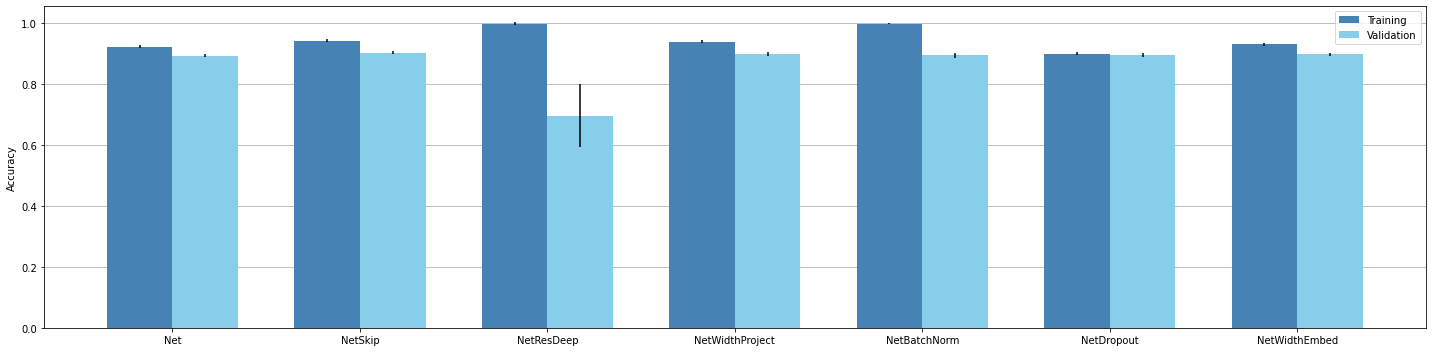

In [51]:
plotting(mean_dict, std_dict)

### Q1

Models has difference in training accuracies. BatchNorm and ResDeep has achived 100% in accuracies. But ResDeep looks overfitted to training dataset. Besides that other models are not so different.<br>
In validation accuracy NetSkip took the best result.

### Q2

In [52]:
# Calculating the number of parameters that are trainable
def get_trainable_parms(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [53]:
# Making a dictionary with the number of parameters
param_dict = {}
for model_name, model in model_dict.items():
    param_dict[model_name] = get_trainable_parms(model)

In [54]:
# funtion for plotting the number of parameters above the bars
def addlabels(x,y, text):
    for i in range(len(x)):
        plt.text(i, y[i], text[i], ha = 'center')

In [59]:
def plot(model_result_dict, model_param_dict):
    # Same as above but with the number of parameters
    fig, ax = plt.subplots(figsize=(20, 5))
    width = 0.35
    x_labels = model_result_dict.keys()
    train_means = [model_result_dict[key]['Training'] for key in x_labels]
    model_param = [model_param_dict[key] for key in x_labels]
    x = np.arange(len(model_result_dict))
    ax.bar(x ,train_means, width, label='Training', color='steelblue')

    ax.set_ylabel('Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.legend()
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    addlabels(x, train_means, model_param)

    fig.tight_layout()
    plt.show()

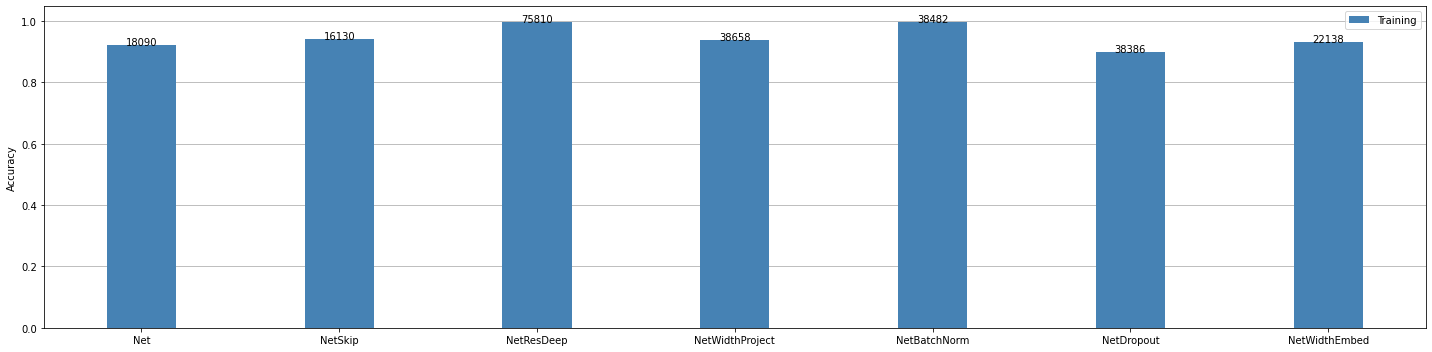

In [60]:
plot(mean_dict, param_dict)

Training accuracies are not so related to the number of trainable parameters. I think accuracies are more realted to the network architecture.<br>
It can be seen that more parameter can get better result but, NetSkip and NetWidthEmbed is better than NetWithProject and NetDropout.

## Part3

In [13]:
class NetSkip10(nn.Module):
    def __init__(self, n_ch1=32):
        super().__init__()
        # needed later in the forward function
        self.n_ch1 = n_ch1
        self.conv1 = nn.Conv2d(3, n_ch1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_ch1, n_ch1 // 2, kernel_size=3, padding=1)
        # go deeper!
        self.conv3 = nn.Conv2d(n_ch1 //2, n_ch1//2, kernel_size = 3, padding = 1)
        # we have now half the size from before
        self.fc1 = nn.Linear(4 * 4 * n_ch1 // 2, 32)
        # changed the number of output units to 10 because the model need to predict 10 class
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        # save the input to layer3
        ln_layer3 = out
        # and add it to the output
        out = F.max_pool2d(torch.relu(self.conv3(out)) + ln_layer3, 2)
        out = out.view(-1, 4 * 4 * self.n_ch1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [32]:
# where to put the data
data_path = './'

# this constructs a CIFAR10 dataset, selects the training part of it, 
# downloads it if necessary, and adds additional transforms that we 
# will need to convert each image to a pytorch tensor AND to provide
# a nice conversion of the RGB images into greyscale
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified
Files already downloaded and verified


In [33]:
# Making a dataloader for training and validation
# Also a dictionary for the dataloaders
train_loader10 = torch.utils.data.DataLoader(cifar10, batch_size=64, shuffle=True, num_workers=4)
val_loader10 = torch.utils.data.DataLoader(cifar10_val, batch_size=64, shuffle=False, num_workers=4)
dataloaders_dict10 = {"train": train_loader10, "val": val_loader10}

In [64]:
# Making 10 different seeds
random_seeds = get_random_seeds(range(1000))[:10]
model = NetSkip10()

In [65]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)

In [66]:
def experiment(random_seeds, model, n_epochs, learning_rate, dataloaders_dict):
    # Same function as above
    # Same as Part1
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    model_dict = {}
    for seed in random_seeds:
        set_seed(seed)
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        loss_fn = nn.CrossEntropyLoss()

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        trained_model, train, val = training_loop(n_epochs, optimizer, model, loss_fn, dataloaders_dict)
        errors = [np.abs(t-v) for t,v in zip(train,val)]
        plt.errorbar(range(1, n_epochs + 1), train, yerr=errors, label="train")
        plt.errorbar(range(1, n_epochs + 1), val, yerr=errors, label="val")
        plt.title("Training and Validation Accuracy for seed {}".format(seed))
        plt.legend(loc="upper left")
        plt.show()
        
        model_dict[str(seed)] = trained_model

    return model_dict

In [58]:
def plot_conusion(models, dataloader_dict):
    device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    # Plotting the confusion matrix
    # Setting the class names for the confusion matrix
    class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
    # Placeholder for confusion matricies
    list_of_confusion_matrices_train = []
    list_of_confusion_matrices_val = []
    # Looping over the models
    for seed, model in models.items():
        model.to(device)
        model.eval()
        with torch.no_grad():
            # Getting the predictions of model for each dataset
            for phase in ['train','val']:
                y_pred = []
                y_true = []
                for imgs, labels in dataloader_dict[phase]:
                    imgs = imgs.to(device)
                    outputs = model(imgs)
                    _, preds = torch.max(outputs, 1)
                    y_pred.append(preds.cpu().numpy())
                    y_true.append(labels.numpy())
                y_pred = np.concatenate(y_pred)
                y_true = np.concatenate(y_true)
                # Making the confusion matrix
                cm = confusion_matrix(y_true, y_pred)
                cm = cm.astype('float') / cm.sum(axis=1)
                # Adding the confusion matrix to the list
                if phase == 'train':
                    list_of_confusion_matrices_train.append(cm)
                else:
                    list_of_confusion_matrices_val.append(cm)

    # average confusion matrix
    cm_train = 100 * sum(list_of_confusion_matrices_train)/len(list_of_confusion_matrices_train)
    cm_val = 100 * sum(list_of_confusion_matrices_val)/len(list_of_confusion_matrices_val)
    # Plotting the confusion matrix for each dataset
    for phase in ['train','val']:
        if phase == 'train':
            disp = ConfusionMatrixDisplay(cm_train, display_labels=class_names)
            fig, ax = plt.subplots(figsize=(20,20))
            ax.set_title("Confusion Matrix for {}".format(phase))
            disp.plot(colorbar=False, cmap='Blues', ax=ax)
        else:
            disp = ConfusionMatrixDisplay(cm_val, display_labels=class_names)
            fig, ax = plt.subplots(figsize=(20,20))
            ax.set_title("Confusion Matrix for {}".format(phase))
            disp.plot(colorbar=False, cmap='Blues', ax=ax)

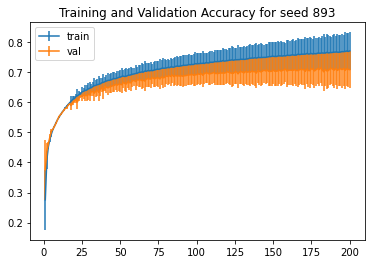

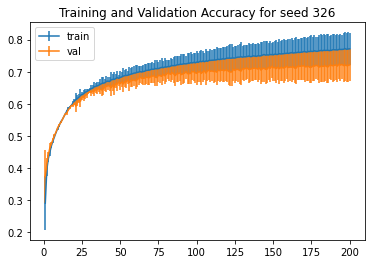

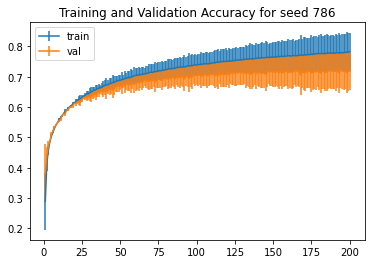

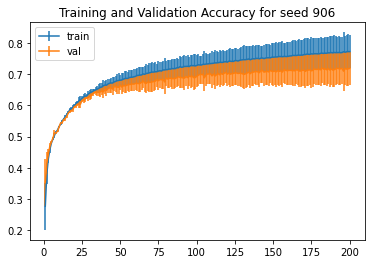

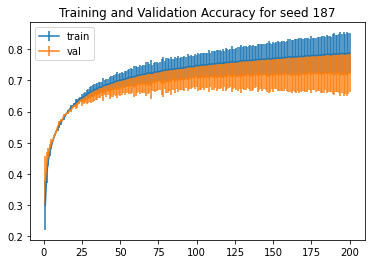

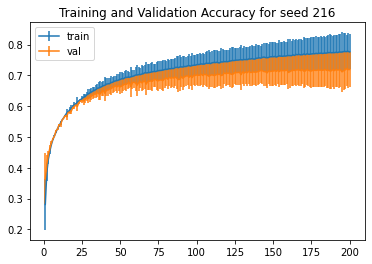

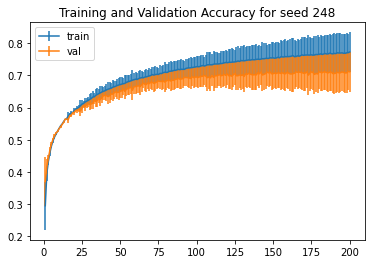

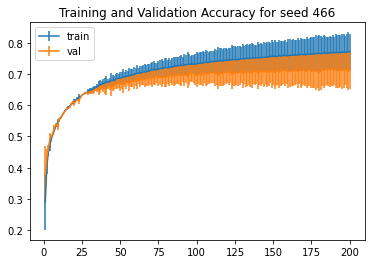

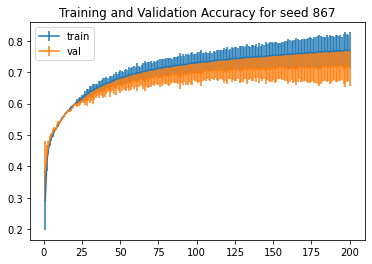

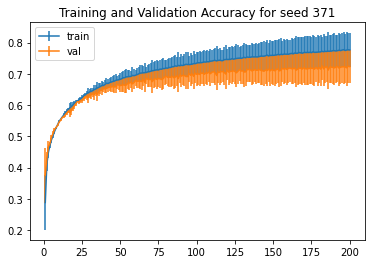

In [74]:
models = experiment(random_seeds, model, 200, 1e-4, dataloaders_dict10)

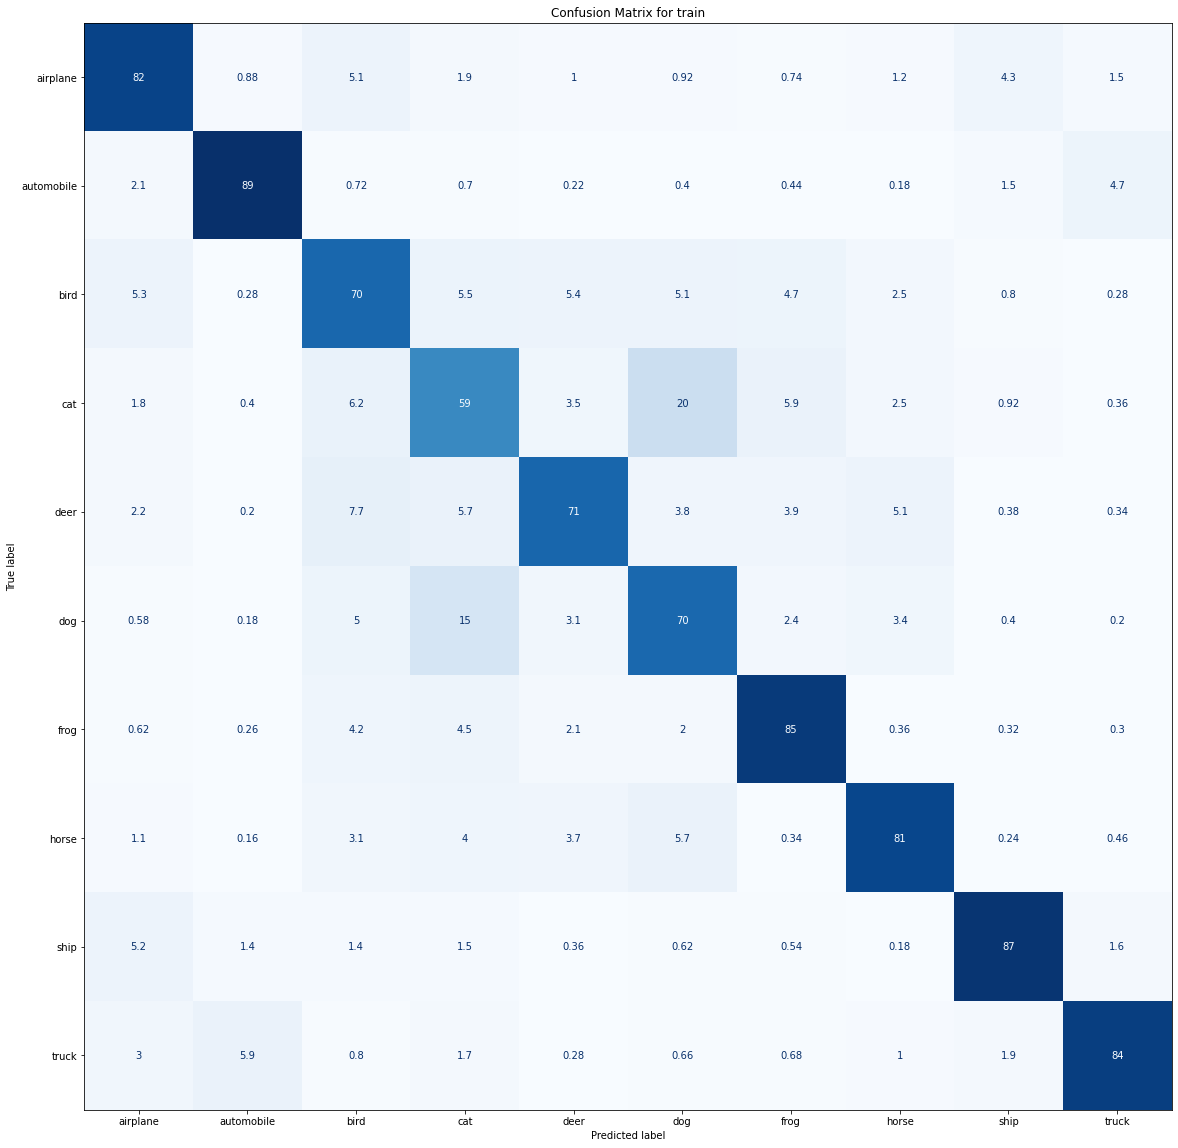

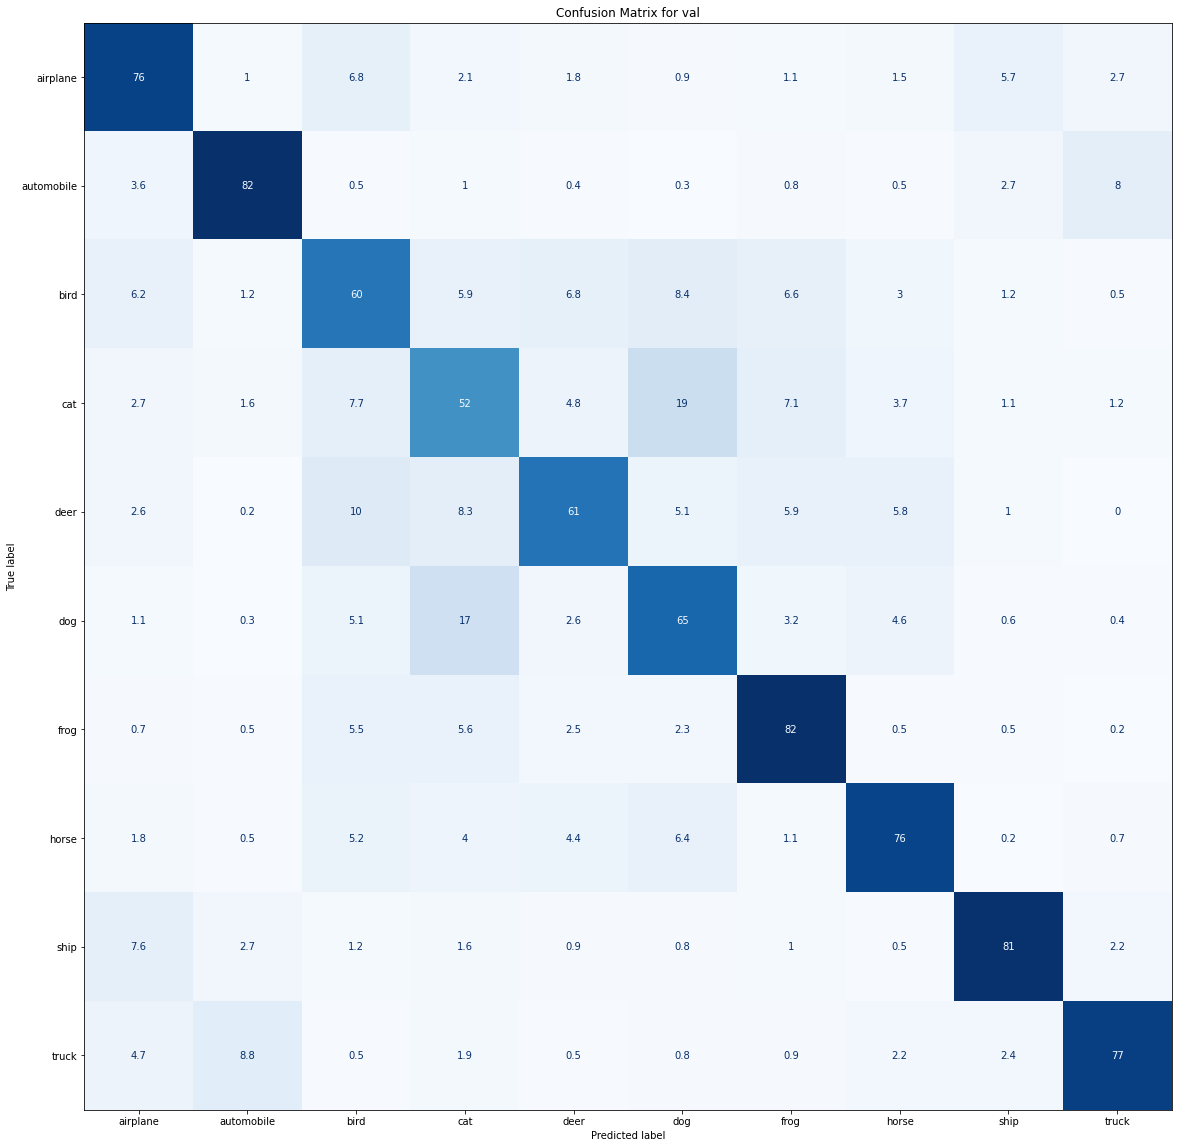

In [59]:
plot_conusion(models, dataloaders_dict10)

### Q1

No the network isn't overfitted.<br>
To make it overfit, there are several ways to make it overfitted.<br>
First, you can shift the data distribution of the train data.<br>
Secondly, you can reduce the amount of train data. The model can train the noise and some pattern of data if there are a little bit of train data.<br>
Or lastly you can increase the models' complexity.<br>


### Q2

From the validation dataset, my model can do well on automobile, ship and frog. They are 82%, 82 % and 81% each.

### Q3

Frog as the smalles differences, 85% from the training set and 82% on the validation set.<br>
For the largest differences are deer and bird, the are 71% and 70 % on the training set and 61% and 60% on the validation set.

### Q4

Yes, it makes sense.<br>
Comparing to the result above, the model predicted frog to bird, or deer to airplane. But this time there are a bit errors, but classes has well classified.<br>
It could better if the batch sizes are larger like 256 or 512. Because the image file resolution is very small.